# Notebook 6: Phases of the Ising Model with Logistic Regression


## Learning Goal
The goal of this notebook is to show how one can employ Logistic Regression to classify the states of the 2D Ising model according to their phase. We will discuss overfitting, regularization, and learn how to use the scikit-learn library. We will also examine the role of the optimizer in making predictions.

## Overview

The energy function of the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.



An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. If successful, this can be used to locate the position of the critical point in more complicated models where an exact analytical solution has so far remained elusive. 

In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for logistic regression. Notice that, for the purposes of applying logistic regression, the 2D spin state of the Ising model will be flattened out to a 1D array, so it will not be easy to learn information about the structure of the contiguous ordered 2D domains [see figure below]. Such information can be incorporated using other methods such as multi-layer deep convolutional neural networks (CNNs), see Secs. IX, X and XI of the review and the corresponding notebooks.

## The 2D Ising Dataset

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$). We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

In [1]:
import numpy as np
import time

import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

# Loading in the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [2]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# Constructing the training and the test sets

In [3]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.1 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (13000, 1600)
Y_train shape: (13000,)

13000 train samples
30000 critical samples
117000 test samples


# Visualizing the states

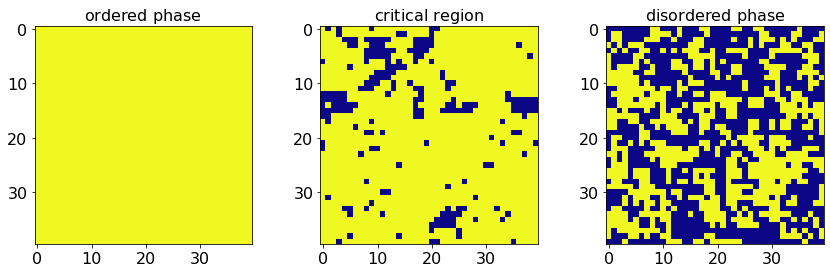

In [4]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

## Cost function, optimizers, regularizers, and performance metrics

In Sec. VII of the review, we have shown that the cross-entropy is a natural cost function used for training a logistic regressor. As we already mentioned, minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: a `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

It is important to note that all these methods have built-in regularizers. Indeed, we did not discuss the role of the regularisor explicitly in the context of Logistic Regression extensively, yet this concept is crucial in order to prevent overfitting, and we encourage the interested reader to play with the different regularization types and regularization strengths and compare model performances. 

Below, we define the accuracy of a classification model on a given data set as the percentage of correctly classified data points. Comparing the accuracy on the training and test data, we obtain a good estimate of the degree of overfitting. Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets [recall that the test set consists of samples which the model has not been trained on]. 

# Run the cell below (this may take several minutes)

accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.5485, 0.4837, 0.5414
finished computing 1/11 iterations in 14.126980304718018 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.5386, 0.4722, 0.5495
finished computing 2/11 iterations in 13.884001731872559 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.5949, 0.5036, 0.5624
finished computing 3/11 iterations in 13.628997802734375 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859
SGD: 0.7820, 0.6840, 0.5913
finished computing 4/11 iterations in 11.260000467300415 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859
SGD: 0.7598, 0.6768, 0.6329
finished computing 5/11 iterations in 10.184999465942383 seconds
accuracy: train, test, critical
liblin: 0.7943, 0.6993, 0.5860
SGD: 0.6160, 0.5793, 0.6860
finished computing 6/11 iterations in 9.573998928070068 seconds
accuracy: train, test, critical
liblin: 0.7938, 0.6993, 0.5876
SGD: 0.4615, 0.4615, 0.3333
finished computing 7/11 iterations in 9.69100046157837 seconds
accuracy: train, test, critical
liblin: 0.7922, 0.6987, 0.5970
SGD: 0.4615, 0.4615, 0.3333
finished computing 8/11 iterations in 8.20600175857544 seconds
accuracy: train, test, critical
liblin: 0.7855, 0.6969, 0.6173
SGD: 0.4615, 0.4615, 0.3333
finished computing 9/11 iterations in 5.8

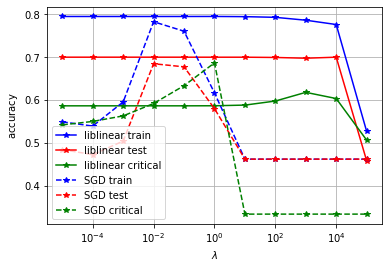

In [5]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):
    start = time.time()
    
    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing {}/11 iterations in {} seconds'.format(i+1, time.time()-start))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

## Interpreting the results

The first thing we can read off the figure above is the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 


### Exercises: ###  

Note that above I have decreased the training set to only 10% of the data as my poor 5 year old laptop was having trouble dealing with such a large training set. Compared to the models on the full dataset with default parameters, most things behave similarly. The main difference is performance of SGD in the critical region which does strangely well for even high $\lambda$, even better than the training error.

- Change the regularization to $L^1$, or $L^1+L^2$ (i.e. elastic net, see Notebook 2 for more details), and study the performance of the model.

See below code. I implemented an L1 regularization for both liblinear and SGD as liblinear does not support elastic nets.

SGD didn't change too much except the sweet spot in lambda from before is now no longer just a single flat feature. Potentially zooming in on this region would show some interesting results (which maybe also exist before and just were hidden!) It mostly seemed to compress the results as L1 tends to be a bit more aggressive than L2.

For liblinear test and train, not much changed except the compression mentioned before. However, 

accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.7625, 0.6945, 0.5651
finished computing 1/11 iterations in 45.7519965171814 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.5415, 0.4747, 0.5544
finished computing 2/11 iterations in 44.16999936103821 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5858


C:\Users\Brian\Anaconda3\envs\ML_PY895\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD: 0.7428, 0.6586, 0.5087
finished computing 3/11 iterations in 46.92200040817261 seconds
accuracy: train, test, critical
liblin: 0.7942, 0.6993, 0.5859
SGD: 0.5385, 0.5385, 0.6667
finished computing 4/11 iterations in 28.610000133514404 seconds
accuracy: train, test, critical
liblin: 0.7943, 0.6992, 0.5860
SGD: 0.5385, 0.5385, 0.6667
finished computing 5/11 iterations in 26.37400221824646 seconds
accuracy: train, test, critical
liblin: 0.7934, 0.6990, 0.5887
SGD: 0.5385, 0.5385, 0.6667
finished computing 6/11 iterations in 26.3759982585907 seconds
accuracy: train, test, critical
liblin: 0.7878, 0.6961, 0.6081
SGD: 0.4615, 0.4615, 0.3333
finished computing 7/11 iterations in 21.2760009765625 seconds
accuracy: train, test, critical
liblin: 0.5390, 0.5387, 0.6668
SGD: 0.4615, 0.4615, 0.3333
finished computing 8/11 iterations in 12.209999561309814 seconds
accuracy: train, test, critical
liblin: 0.5385, 0.5385, 0.6667
SGD: 0.4615, 0.4615, 0.3333
finished computing 9/11 iterations in 5.27

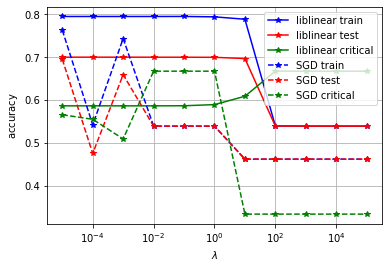

In [6]:
# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):
    start = time.time()

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='saga', penalty='l1')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing {}/11 iterations in {} seconds'.format(i+1, time.time()-start))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

- Try out different solvers supported by `LogisticRegression()`, [see online scikit documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How do they compare to `liblinear` and `SGD`?

See code below. I tested out SAGA (which is supposed to be fast and work well on large datasets) and LBFGS (which is ann approximation to Newton's method which is supposed to work well on small datasets). Both are using default options (L2 regularization).

The two perform nearly exactly the same as each other. They are also very similar to liblinear except that they fall off quicker at large $\lambda$. Additionally, they also display an uptick in the critical data for large $\lambda$.

accuracy: train, test, critical
saga: 0.7942, 0.6993, 0.5859
lbfgs: 0.7944, 0.6993, 0.5861
finished computing 1/11 iterations in 20.75783395767212 seconds
accuracy: train, test, critical
saga: 0.7942, 0.6993, 0.5859
lbfgs: 0.7943, 0.6993, 0.5860
finished computing 2/11 iterations in 20.90099835395813 seconds
accuracy: train, test, critical
saga: 0.7942, 0.6993, 0.5859
lbfgs: 0.7942, 0.6993, 0.5860
finished computing 3/11 iterations in 20.17400074005127 seconds
accuracy: train, test, critical
saga: 0.7942, 0.6993, 0.5859
lbfgs: 0.7942, 0.6993, 0.5860
finished computing 4/11 iterations in 20.674999713897705 seconds
accuracy: train, test, critical
saga: 0.7942, 0.6993, 0.5859
lbfgs: 0.7942, 0.6993, 0.5859
finished computing 5/11 iterations in 21.51400065422058 seconds
accuracy: train, test, critical
saga: 0.7943, 0.6993, 0.5861
lbfgs: 0.7944, 0.6992, 0.5862
finished computing 6/11 iterations in 19.790999174118042 seconds
accuracy: train, test, critical
saga: 0.7935, 0.6993, 0.5878
lbfgs: 

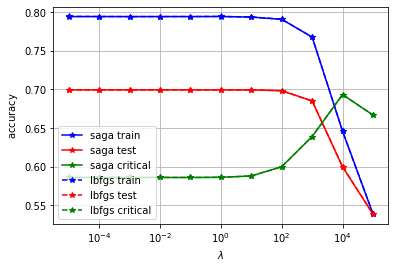

In [7]:
# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy2=np.zeros(lmbdas.shape,np.float64)
test_accuracy2=np.zeros(lmbdas.shape,np.float64)
critical_accuracy2=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):
    start = time.time()
    
    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='saga')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('saga: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define logistic regressor
    logreg2=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='lbfgs')

    # fit training data
    logreg2.fit(X_train, Y_train)

    # check accuracy
    train_accuracy2[i]=logreg2.score(X_train,Y_train)
    test_accuracy2[i]=logreg2.score(X_test,Y_test)
    critical_accuracy2[i]=logreg2.score(X_critical,Y_critical)
    
    
    print('lbfgs: %0.4f, %0.4f, %0.4f' %(train_accuracy2[i],test_accuracy2[i],critical_accuracy2[i]) )

    print('finished computing {}/11 iterations in {} seconds'.format(i+1, time.time()-start))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='saga train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='saga test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='saga critical')

plt.semilogx(lmbdas,train_accuracy2,'*--b',label='lbfgs train')
plt.semilogx(lmbdas,test_accuracy2,'*--r',label='lbfgs test')
plt.semilogx(lmbdas,critical_accuracy2,'*--g',label='lbfgs critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

- One can expect the regressor to be maximally confused exactly at the critical point. Take the data states for the closest temperature, i.e. $T/J=2.5$, and check the performance of the model. Do we get an accuracy of about $50\%$? Does this depend on the proportion of ordered to disordered states in the training set?

When there is roughly equal ordered and disoredered states in the training data, we get 50% accuracy. However, more disordered states than ordered states causes the accuracy to decrease and vice versa. The actual states should all be disordered. It seems like when the model has less information about a category, it is more likely to place a confusing new data point into that category than the one that is understood better.

accuracy: train, test, critical
liblin: 0.9377, 0.9206, 0.3307
finished computing 1/10 iterations in 5.129978895187378 seconds
accuracy: train, test, critical
liblin: 0.8132, 0.6617, 0.3238
finished computing 2/10 iterations in 5.375001430511475 seconds
accuracy: train, test, critical
liblin: 0.6608, 0.4430, 0.4141
finished computing 3/10 iterations in 5.950999736785889 seconds
accuracy: train, test, critical
liblin: 0.7959, 0.6081, 0.5091
finished computing 4/10 iterations in 6.762998819351196 seconds
accuracy: train, test, critical
liblin: 0.8508, 0.6693, 0.5480
finished computing 5/10 iterations in 9.560997724533081 seconds
accuracy: train, test, critical
liblin: 0.8717, 0.7199, 0.5460
finished computing 6/10 iterations in 14.455000638961792 seconds
accuracy: train, test, critical
liblin: 0.9830, 0.7640, 0.5533
finished computing 7/10 iterations in 115.98400044441223 seconds
accuracy: train, test, critical
liblin: 1.0000, 0.8360, 0.5897
finished computing 8/10 iterations in 25.51999

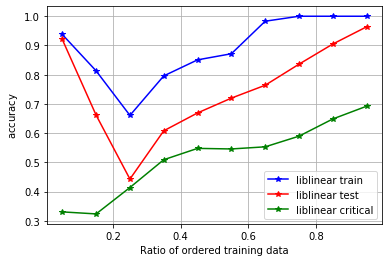

In [8]:
X_supercrit = X_critical[20000:,:]
Y_supercrit = Y_critical[20000:]



# define regularisation parameter
lmbda=1e-2

# ratio of ordered in total dataset
order_ratios = np.linspace(0.05,0.95,10)

# preallocate data
train_accuracy=np.zeros(order_ratios.shape,np.float64)
test_accuracy=np.zeros(order_ratios.shape,np.float64)
critical_accuracy=np.zeros(order_ratios.shape,np.float64)

# loop over regularisation strength
for i,ord_ratio in enumerate(order_ratios):
    start = time.time()
    
    # define training and test data sets
    ord_index = np.random.choice(X_ordered.shape[0], (X_ordered.shape[0]*ord_ratio).astype(int), replace=False)
    dis_index = np.random.choice(X_disordered.shape[0], (X_disordered.shape[0]*(1-ord_ratio)).astype(int), replace=False)
    X=np.concatenate((X_ordered[ord_index,:],X_disordered[dis_index,:]))
    Y=np.concatenate((Y_ordered[ord_index],Y_disordered[dis_index]))

    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
    
    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    print('finished computing {}/10 iterations in {} seconds'.format(i+1, time.time()-start))

# plot accuracy against regularisation strength
plt.plot(order_ratios,train_accuracy,'*-b',label='liblinear train')
plt.plot(order_ratios,test_accuracy,'*-r',label='liblinear test')
plt.plot(order_ratios,critical_accuracy,'*-g',label='liblinear critical')

plt.xlabel('Ratio of ordered training data')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

- Take the regressor trained on the square lattice Ising model, and try to predict the phases on a different lattice geometry (e.g. triangular or honeycomb). What accuracy do you obtain? Can you roughly locate the critical point in this new model? Note that this requires you to generate your own dataset using Monte-Carlo sampling.
